## Overview/To-Do

This one tries a different, more realistic detecor layouout.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap

In [2]:
from BurstSim.GRB import *
from BurstSim.Detector import *
from BurstSim.Spacecraft import *
from BurstSim.Stats import calcNorms, addErrors, calcNormsWithError

## Set up
These are actually the default pointings but I put it here to show you how to set up various detectors.  Just six, smaller detectors this time.

In [3]:
#Evenly spaced around azimuth
#Staggered in zenith
#Arbitrary type
pointings = {'01': ('90:0:0','45:0:0'),
             '02': ('180:0:0','45:0:0'),
             '03': ('270:0:0','45:0:0'),
             '04': ('360:0:0','45:0:0')}
#             '05': ('200:0:0','10:0:0'),
#             '06': ('240:0:0','10:0:0'),
#             '07': ('280:0:0','10:0:0'),
#             '08': ('320:0:0','10:0:0'),
#             '09': ('360:0:0','10:0:0')}

Set up a spacecraft object with the pointings of the detector you've decided on.  The spacecraft defaults to a position above DC at an elevation of 550 km (about the orbit of Fermi).

In [4]:
spacecraft = Spacecraft(pointings, window = 0.1)

Set up some points in RA/Dec to calculate exposures and then access the 'exposure' function of the detector objects within the spacecraft object to plot the exposure.

In [5]:
res = 250
rr,dd = np.meshgrid(np.linspace(0,360,res,endpoint=False),np.linspace(-90,90,res))
exposure_positions = np.vstack([rr.ravel(),dd.ravel()])

In [6]:
exposures = np.array([[detector.exposure(position[0],position[1]) for position in exposure_positions.T] 
                      for detector in spacecraft.detectors])

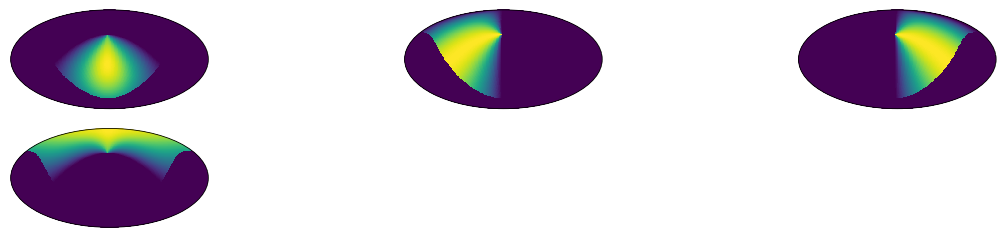

In [7]:
plt.figure(figsize=(20,len(pointings)))
#m = Basemap(projection='moll',lon_0=180.,resolution='c')
#x,y = m(rr,dd)
x,y = (rr-180.)*np.pi/180.,dd*np.pi/180.
for sp in range(len(pointings)):
    m=plt.subplot(2, len(pointings)/2+1, sp+1, projection="mollweide")
    m.axes.xaxis.set_ticklabels([])
    m.axes.yaxis.set_ticklabels([])
    m.pcolormesh(x,y,exposures[sp].reshape((res,res)))
plt.show()

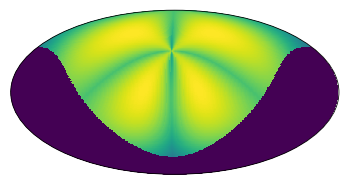

In [8]:
plt.figure(figsize=(20,20))
#m = Basemap(projection='moll',lon_0=180,resolution='c')
#m.drawparallels(np.arange(-90.,120.,30.))
#m.drawmeridians(np.arange(0.,420.,60.))
#x,y = m(rr,dd)
#x,y = (rr-180.)*np.pi/180.,dd*np.pi/180.
m=plt.subplot(2, len(pointings)/2+1, sp+1, projection="mollweide")
m.axes.xaxis.set_ticklabels([])
m.axes.yaxis.set_ticklabels([])
m.pcolormesh(x,y,exposures.sum(axis=0).reshape((res,res)))
#plt.colorbar()
plt.show()

In [12]:
rr,dd = np.meshgrid(np.linspace(0,360,100,endpoint=False),np.linspace(-90,90,100))
training_positions = np.vstack([rr.ravel(),dd.ravel()])

In [13]:
exposures = np.array([[detector.exposure(position[0],position[1]) for position in training_positions.T] 
                     for detector in spacecraft.detectors])

In [14]:
training_grbs = [GRB(position[0],position[1],binz=.001) for position in training_positions.T[exposures.sum(axis=0) > 0.]]

/Users/jracusin/anaconda/lib/python2.7/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


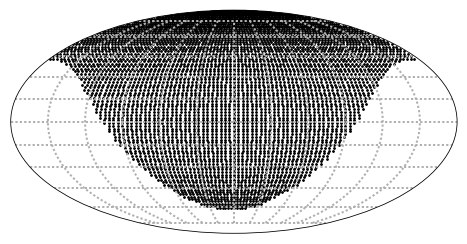

In [15]:
pos = np.array([[grb.eph._ra*180./np.pi,grb.eph._dec*180./np.pi] for grb in training_grbs])
plt.figure(figsize=(8,10))
m=plt.subplot(111, projection="mollweide")
x,y = (pos[:,0]-180.)*np.pi/180.,pos[:,1]*np.pi/180.
m.scatter(x,y,3,marker='o',color='k')
m.axes.xaxis.set_ticklabels([])
m.axes.yaxis.set_ticklabels([])
m.grid(linestyle=':', linewidth=2)
#m = Basemap(projection='moll',lon_0=180,resolution='c')
#m.drawparallels(np.arange(-90.,120.,30.))
#m.drawmeridians(np.arange(0.,420.,60.))
#x,y = m(pos[:,0],pos[:,1])
#m.scatter(x,y,3,marker='o',color='k')
plt.show()

In [16]:
training_counts = spacecraft.throw_grbs(training_grbs,scaled=True)

BurstSim/Detector.py:150: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  resp_re = self.response[trunc:].reshape(-1,window)
BurstSim/Detector.py:151: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._sign_time = np.arange(len(self.response))[trunc:].reshape(-1,window)[1:,0]
BurstSim/Detector.py:66: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.sum(self.response[self.trigger_time:self.trigger_time+window])
BurstSim/Spacecraft.py:80: RuntimeWarning: invalid value encountered in divide
  for idx,rec in enumerate(grb_rec)]


## Setup and throw a random sample of GRBs

Note that I'm only throwing them in the north since the Earth blocks the south.

In [17]:
real_positions = np.array(zip(360.*np.random.random_sample(2000),180.*np.random.random_sample(2000)-90.))

In [18]:
exposures = np.array([[detector.exposure(position[0],position[1]) for position in real_positions]
                      for detector in spacecraft.detectors])

In [19]:
real_grbs = [GRB(position[0],position[1],binz=0.001) for position in real_positions[exposures.sum(axis=0) > 0.]]

In [20]:
#np.shape(real_grbs)

In [21]:
real_counts = spacecraft.throw_grbs(real_grbs, scaled=True)

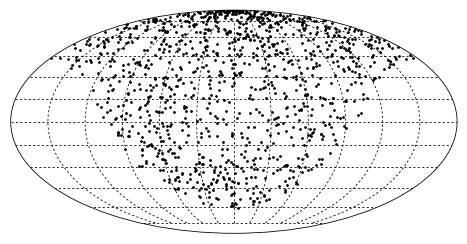

In [22]:
pos = np.array([[grb.eph._ra*180./np.pi,grb.eph._dec*180./np.pi] for grb in real_grbs])
plt.figure(figsize=(8,10))
m=plt.subplot(111, projection="mollweide")
m.scatter((pos[:,0]-180)*np.pi/180.,pos[:,1]*np.pi/180.,3,marker='o',color='k')
m.axes.xaxis.set_ticklabels([])
m.axes.yaxis.set_ticklabels([])
plt.grid(linestyle=':',color='k')
plt.show()

In [23]:
norms = calcNorms(real_counts,training_counts)

In [24]:
real_counts_err = addErrors(real_counts,training_counts)

In [25]:
norms_errp, norms_errm = calcNormsWithError(real_counts,training_counts,real_counts_err)

Find the minimum distance of each GRB.

In [26]:
loc_mins = [norm.argmin() for norm in norms]
loc_mins_errm = [norm.argmin() for norm in norms_errm]
loc_mins_errp = [norm.argmin() for norm in norms_errp]

Now, calculate the distance from the real GRB to the training one picked out from the distance measuremnt above.

In [27]:
errors = [eph.separation(grb.eph,training_grbs[loc_mins[idx]].eph)*180./np.pi for idx,grb in enumerate(real_grbs)]
errors_errm = [eph.separation(grb.eph,training_grbs[loc_mins_errm[idx]].eph)*180./np.pi for idx,grb in enumerate(real_grbs)]
errors_errp = [eph.separation(grb.eph,training_grbs[loc_mins_errp[idx]].eph)*180./np.pi for idx,grb in enumerate(real_grbs)]

Plot and save the cumulative distribution of this error.

[]

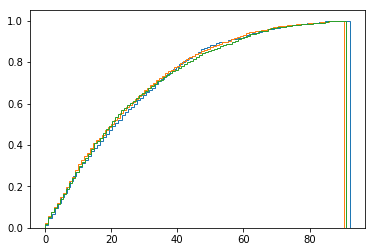

In [28]:
hist_data = plt.hist(errors,bins=100,normed=1, histtype='step', cumulative=True)
hist_data_errm = plt.hist(errors_errm,bins=100,normed=1, histtype='step', cumulative=True)
hist_data_errp = plt.hist(errors_errp,bins=100,normed=1, histtype='step', cumulative=True)
plt.plot()

## The 1-sigma error is around 68%.  Quick function to find the distance value that most closely matches 0.68.

In [29]:
avg_stat = np.average([hist_data_errm[1][np.abs(hist_data_errm[0] - 0.68).argmin()],
                       hist_data_errp[1][np.abs(hist_data_errp[0] - 0.68).argmin()]])

In [30]:
print 'Systematic Error: {:,.2f}'.format(hist_data[1][np.abs(hist_data[0] - 0.68).argmin()])

Systematic Error: 32.30


In [31]:
print 'Statistical Error: {:,.2f}'.format(avg_stat)

Statistical Error: 31.36


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

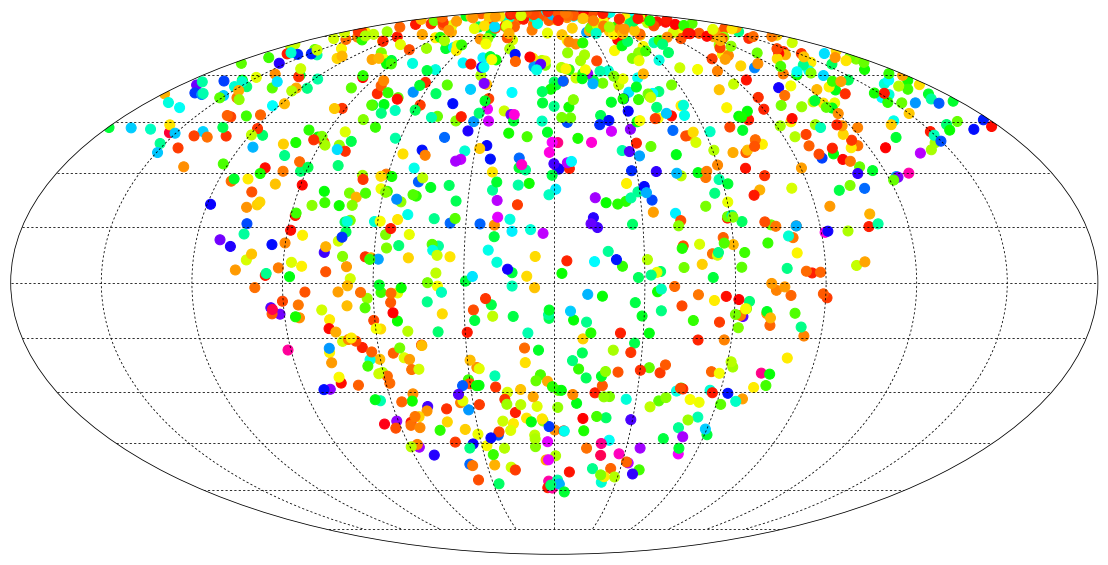

In [34]:
pos = np.array([[grb.eph._ra*180./np.pi,grb.eph._dec*180./np.pi] for grb in real_grbs])
plt.figure(figsize=(20,10))
m=plt.subplot(111, projection="mollweide")
m.scatter((pos[:,0]-180)*np.pi/180.,pos[:,1]*np.pi/180.,marker='o',c=errors,s=100.,cmap=plt.cm.hsv)
m.axes.xaxis.set_ticklabels([])
m.axes.yaxis.set_ticklabels([])
plt.grid(linestyle=':',color='k')

#m = Basemap(projection='moll',lon_0=180,resolution='c')
#m.drawparallels(np.arange(-90.,120.,30.))
#m.drawmeridians(np.arange(0.,420.,60.))
#x,y = m(pos[:,0],pos[:,1])
#m.scatter(x,y,marker='o',c=errors,s=100.,cmap=plt.cm.hsv)
plt.colorbar(shrink=0.5)
plt.savefig('Sky Map with Errors.pdf', transparent = True)
plt.show()